# Chapter 3c: Rock facies classification using SVM (& decision trees)

In this notebook, you will apply what we learned in the two previous parts of Chapter 3. We will also apply the general preprocessing method of __data standardization__. In the next and final notebook of chapter 3, we will focus our attention on decision trees; therefore this is the last time we will consider SVM in this course.

## 1. Introduction

### 1.1. Data set history

The dataset we will use in this notebook is __log data from nine wells that have been labeled with a facies type based on oberservation of core__. We will use this log data to train 2 types of machine learning classifiers (SVM and decision trees) to classify facies types. The dataset originally comes from a [class excercise from The University of Kansas on Neural Networks and Fuzzy Systems](http://www.people.ku.edu/~gbohling/EECS833/). This exercise was based on a consortium project to use machine learning techniques to create a reservoir model of the largest gas fields in North America, the Hugoton and Panoma Fields (Dubois et al., 2007). The same dataset was later used in a machine learning challenge, the first of its kind, in the geophysical tutorial of The Leading Edge journal. We will first reproduce the original SVM baseline model (Hall, 2016). You will then test different decision tree classifiers to try to get the best result, as tree ensembles have been shown to perform best in that challenge (Hall & Hall, 2017).

### 1.2. References

* Dubois et al. (2007), Comparison of four approaches to a rock facies classification problem. Computers & Geosciences, 33 (5), 599–617
* Hall (2016), Facies classification using machine learning. The Leading Edge, 35 (10), 906-909
* Hall & Hall (2017), Distributed collaborative prediction: Results of the machine learning contest. The Leading Edge, Mar. issue, 267-269


## 2. Data exploration

### 2.1. Data import & preliminary exploration

We will first load the training data from 9 wells, and take a look at what we have to work with.  We will plot the data from a couple wells, and create cross plots to look at the variation within the data.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

**EXERCISE 1:** Load the data and print the resulting data frame.

In [2]:
filename = 'Facies_training_data.csv'

# YOUR CODE HERE
import pandas as pd
training_data = pd.read_csv(filename)

In [3]:
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
3227,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
3228,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
3229,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
3230,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


This data is from the Council Grove gas reservoir in Southwest Kansas.  The Panoma Council Grove Field is predominantly a carbonate gas reservoir encompassing 2700 square miles in Southwestern Kansas.  This dataset is from eight wells (with 3232 examples), consisting of a set of seven predictor variables and a rock facies (class) for each example vector and validation (test) data (830 examples from two wells) having the same seven predictor variables in the feature vector.  Facies are based on examination of cores from nine wells taken vertically at half-foot intervals. Predictor variables include five from wireline log measurements and two geologic constraining variables that are derived from geologic knowledge. These are essentially continuous variables sampled at a half-foot sample rate. 

The seven predictor variables are:
* Five wire line log curves include [gamma ray](http://petrowiki.org/Gamma_ray_logs) (GR), [resistivity logging](http://petrowiki.org/Resistivity_and_spontaneous_%28SP%29_logging) (ILD_log10),
[photoelectric effect](http://www.glossary.oilfield.slb.com/en/Terms/p/photoelectric_effect.aspx) (PE), [neutron-density porosity difference and average neutron-density porosity](http://petrowiki.org/Neutron_porosity_logs) (DeltaPHI and PHIND). Note, some wells do not have PE.
* Two geologic constraining variables: nonmarine-marine indicator (NM_M) and relative position (RELPOS)

The nine discrete facies (classes of rocks) are: 
1. Nonmarine sandstone
2. Nonmarine coarse siltstone 
3. Nonmarine fine siltstone 
4. Marine siltstone and shale 
5. Mudstone (limestone)
6. Wackestone (limestone)
7. Dolomite
8. Packstone-grainstone (limestone)
9. Phylloid-algal bafflestone (limestone)

These facies aren't discrete, and gradually blend into one another. Some have neighboring facies that are rather close.  Mislabeling within these neighboring facies can be expected to occur.  The following table lists the facies, their abbreviated labels and their approximate neighbors.

Facies |Label| Adjacent Facies
:---: | :---: |:--:
1 |SS| 2
2 |CSiS| 1,3
3 |FSiS| 2
4 |SiSh| 5
5 |MS| 4,6
6 |WS| 5,7
7 |D| 6,8
8 |PS| 6,7,9
9 |BS| 7,8

Let's clean up this dataset.  The 'Well Name' and 'Formation' columns can be turned into a categorical data type.  

In [4]:
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()

[SHRIMPLIN, SHANKLE, LUKE G U, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (8, object): [SHRIMPLIN, SHANKLE, LUKE G U, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]

In [5]:
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,4.422030,2875.824567,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,2.504243,131.006274,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2791.000000,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,4.000000,2893.500000,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,6.000000,2980.000000,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,9.000000,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


**EXERCISE 2:** Remove a single well, named `SHANKLE` to use as a blind test later. _Hint: filter the data frame `df` using a condition of the form `df['col_name'] == selected_name`) to define the indices to be kept in the data frame._

In [6]:
# YOUR CODE HERE
blind = training_data[training_data['Well Name'] == 'SHANKLE']
training_data = training_data[training_data['Well Name'] != 'SHANKLE']



### 2.2. Data visualization

Before we plot the well data, let's define a color map so the facies are represented by consistent color in all the plots in this tutorial.  We also create the abbreviated facies labels, and add those to the `facies_vectors` dataframe.

In [7]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00','#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS','WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)

Let's take a look at the data from individual wells in a more familiar log plot form.  We will create plots for the five well log variables, as well as a log for facies labels.

In [8]:
# github.com/seg/tutorials/tree/master/1504_Seismic_petrophysics_1
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

Placing the log plotting code in a function will make it easy to plot the logs from multiples wells, and can be reused later to view the results when we apply the facies classification model to other wells.  The function was written to take a list of colors and facies labels as parameters.  

**EXERCISE 3:** Display the log plots for the well `SHRIMPLIN` using the function just defined.

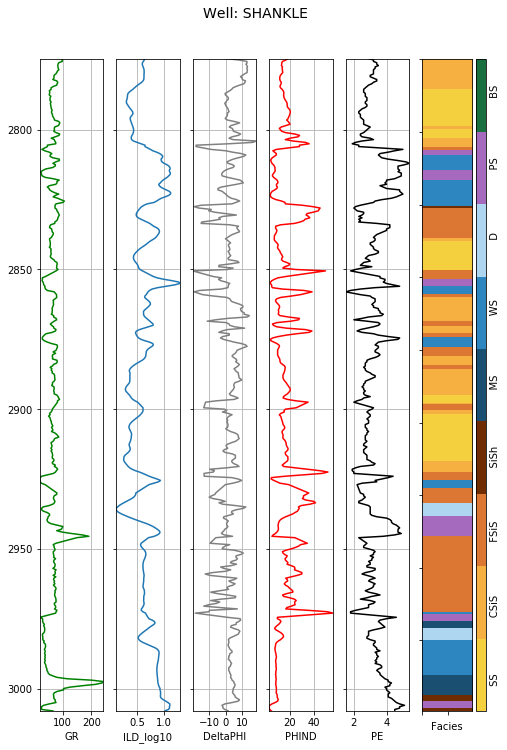

In [9]:
# YOUR CODE HERE
make_facies_log_plot(blind, facies_colors)

In addition to individual wells, we can look at how the various facies are represented by the entire training set.  Let's plot a histogram of the number of training examples for each facies class.

SS      170
CSiS    649
FSiS    498
SiSh    177
MS      198
WS      391
D        81
PS      458
BS      161
Name: Facies, dtype: int64

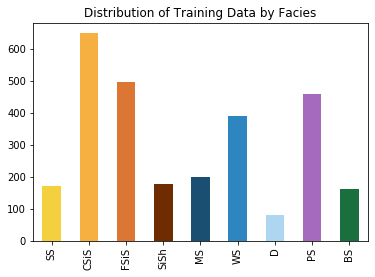

In [10]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = training_data['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_labels

facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Training Data by Facies')
facies_counts

This shows the distribution of examples by facies for the examples in the training set.  Dolomite (facies 7) has the fewest with 81 examples.  Depending on the performance of the classifier we are going to train, we may consider getting more examples of these facies.

Crossplots are a familiar tool in the geosciences to visualize how two properties vary with rock type.  This dataset contains 5 log variables, and scatter matrix can help to quickly visualize the variation between all the variables in the dataset. Each pane in the plot below shows the relationship between two of the variables on the x and y axis, with each point is colored according to its facies. The same colormap is used to represent the 9 facies. 

D:\software\anaconda\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  
D:\software\anaconda\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
D:\software\anaconda\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
D:\software\anaconda\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
D:\software\anaconda\lib\_collections_abc.py:841: MatplotlibDepreca

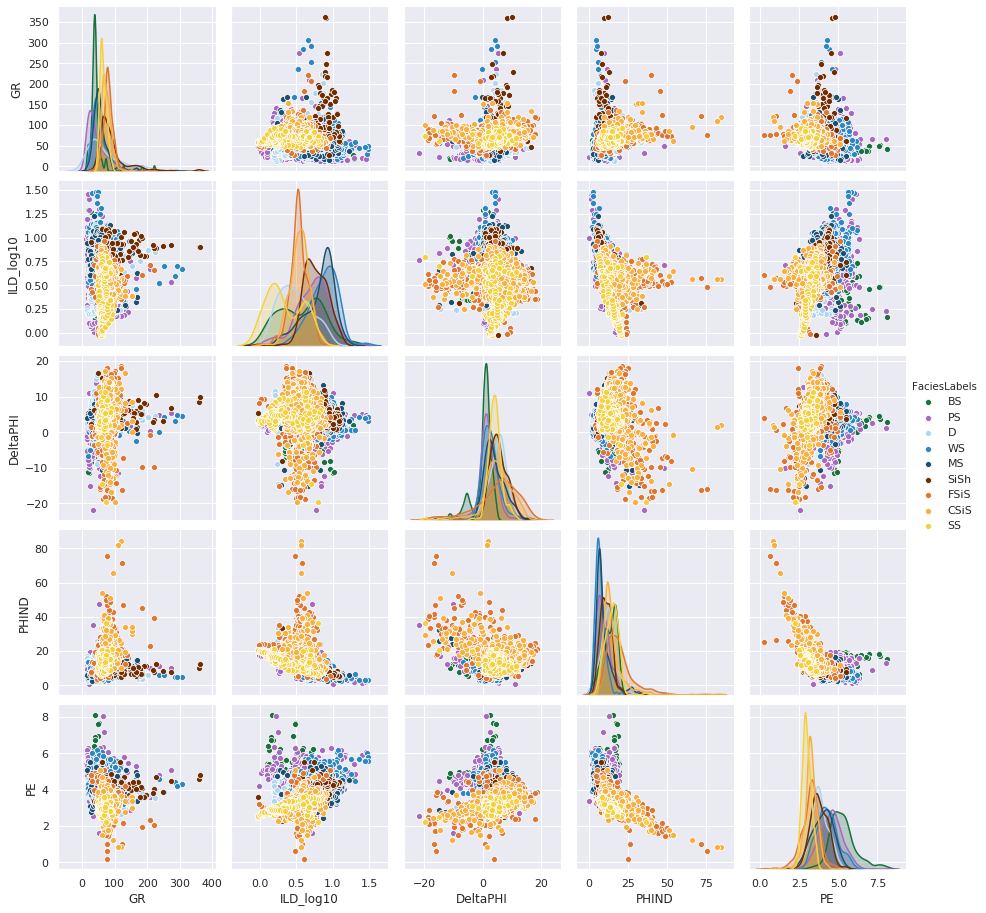

In [11]:
#save plot display settings to change back to when done plotting with seaborn
inline_rc = dict(mpl.rcParams)

sns.set()
sns.pairplot(training_data.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=list(reversed(facies_labels)))

#switch back to default matplotlib plot style
mpl.rcParams.update(inline_rc)

**EXERCISE 4:** What is the main observation we can make from those scatter plots? Can any SVM model be used to classify the lithofacies?

_YOUR ANSWER HERE_ Answer: the data have the some label are more likely to have the similar value, so I think SVM can be used to  classify the lithofacies.

###  2.3. Data standardization

Now we extract just the feature variables we need to perform the classification. The predictor variables are the five wireline values and two geologic constraining variables. We also get a vector of the facies labels that correspond to each feature vector.

**EXERCISE 5:** Define `feature_vectors` by removing the columns from `training_data` which are not features by using `df.drop([ColumnName1, ColumnName2, ...], axis = 1)`

In [12]:
correct_facies_labels = training_data['Facies'].values

# YOUR CODE HERE

feature_vectors = training_data.drop(['Facies', 'Formation', 'Well Name', 'Depth','FaciesLabels'], axis=1)
feature_vectors.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000
mean,66.249445,0.644637,3.754963,13.118929,3.805693,1.523895,0.523057
std,31.610849,0.241922,5.045916,7.389665,0.894118,0.499518,0.287499
min,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,46.081500,0.497000,1.300000,8.165000,3.200000,1.000000,0.276500
50%,65.541000,0.627000,3.581000,11.900000,3.600000,2.000000,0.529000
75%,80.714000,0.812323,6.500000,16.144000,4.400000,2.000000,0.771500
max,361.150000,1.480000,18.500000,84.400000,8.094000,2.000000,1.000000


Scikit includes a [preprocessing](http://scikit-learn.org/stable/modules/preprocessing.html) module that can 'standardize' the data (giving each variable zero mean and unit variance, also called *whitening*).  Many machine learning algorithms assume features will be standard normally distributed data (ie: Gaussian with zero mean and unit variance).  The factors used to standardize the training set must be applied to any subsequent feature set that will be input to the classifier.  The `StandardScalar` class can be fit to the training set, and later used to standardize any training data.

In [13]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)
feature_vectors

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,78.260,0.661,14.200,12.565,4.100,1,0.979
2,79.050,0.658,14.800,13.050,3.600,1,0.957
3,86.100,0.655,13.900,13.115,3.500,1,0.936
4,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...
3227,46.719,0.947,1.828,7.254,3.617,2,0.685
3228,44.563,0.953,2.241,8.013,3.344,2,0.677
3229,49.719,0.964,2.925,8.013,3.190,2,0.669
3230,51.469,0.965,3.083,7.708,3.152,2,0.661


**EXERCISE 6:** Prove that the original features have been scaled to zero mean and unit standard deviation. Take only one feature as example (e.g. `GR`). _Hint: Notice first that the two data structures, `feature_vectors` and `scaled_features`, are of different types (use `type(x)` to check)._

In [14]:
# YOUR CODE HERE
print(type(feature_vectors))
print(type(scaled_features))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [15]:
print(    'Mean and variance of  GR feature: %e %e'          % (np.mean(feature_vectors['GR']), np.std(feature_vectors['GR']))   )
print(  'Mean and variance of scaled GR feature: %e %e'      % (np.mean(scaled_features[:,0]), np.std(scaled_features[:,0])))

Mean and variance of  GR feature: 6.624945e+01 3.160517e+01
Mean and variance of scaled GR feature: -1.021262e-17 1.000000e+00


## 3. SVM baseline model

We will create a facies classifier using SVM. Remember that the SVM is a map of the feature vectors as points in a multi dimensional space, mapped so that examples from different facies are divided by a clear gap that is as wide as possible.

### 3.1. A first vanilla model

A _vanilla model_ means using the default parameters of that model.

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import svm

**EXERCISE 7:** Split the data into training set and test set using 10% of the data for testing. Use `random_state = 42` so that everyone gets the same  data split. Then define and fit a vanila SVM. Finally predict the facies for the test set.

In [17]:
# YOUR CODE HERE
#X_train, X_test, y_train, y_test = ?
X_train, X_test, y_train, y_test =train_test_split( scaled_features, correct_facies_labels, test_size =0.1, random_state = 42)
model_SVM = svm.SVC()
model_SVM.fit(X_train, y_train)
predicted_labels = model_SVM.predict(X_test)


As we have already learned in previous lectures, the entries of a confusion matrix `C[i][j]` are equal to the number of observations predicted to have facies `j`, but are known to have facies `i`. To simplify reading the confusion matrix, a function has been written for the original competition to display the matrix along with facies labels and various error metrics (`classification_utilities.py`).

In [18]:
from classification_utilities import display_cm, display_adj_cm

conf = confusion_matrix(y_test, predicted_labels)
display_cm(conf, facies_labels, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    12    11     1                                        24
     CSiS          40    18                                        58
     FSiS          18    22                                        40
     SiSh           1          10           4           1          16
       MS           1           2          21     1     5          30
       WS                       1          23           9     2    35
        D                       1                 5     5          11
       PS                             2    10          37     2    51
       BS                                   1           3    10    14


C:\Users\79092\Desktop\地球科学与机器学习\chapter3\classification_utilities.py:15: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * (precision * recall) / (precision + recall)


The entries along the diagonal are the facies that have been correctly classified.  Below we define two functions that will give an overall value for how the algorithm is performing.  The accuracy is defined as the number of correct classifications divided by the total number of classifications.

In [19]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

As noted above, the boundaries between the facies classes are not all sharp, and some of them blend into one another.  The error within these 'adjacent facies' can also be calculated.

**EXERCISE 8:** Define an array to represent the facies adjacent to each other.  For facies label `i`, `adjacent_facies[i]` is an array of the adjacent facies labels. Then complete the accuracy function `accuracy_adjacent` so that a prediction is correct when an adjacent facies is observed.

In [20]:
# YOUR CODE HERE
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
   nb_classes = conf.shape[0]
   total_correct = 0.
   for i in np.arange(0,nb_classes):
       total_correct += conf[i][i]
       for j in adjacent_facies[i]:
           total_correct += conf[i][j]
   return total_correct / sum(sum(conf))
print('Facies classification accuracy = %f' % accuracy(conf))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))

Facies classification accuracy = 0.569892
Adjacent facies classification accuracy = 0.892473


In [21]:
print('Facies classification accuracy = %f' % accuracy(conf))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))

Facies classification accuracy = 0.569892
Adjacent facies classification accuracy = 0.892473


### 3.2. SVM hyperparameter tuning

The classifier so far has been built with the default parameters.  However, we may be able to get improved classification results with optimal parameter choices.

We will consider two parameters.  As we learned in chapter 3a, the parameter `C` is a regularization factor, and tells the classifier how much we want to avoid misclassifying training examples.  A large value of `C` will try to correctly classify more examples from the training set, but if `C` is too large  it may 'overfit' the data and fail to generalize when classifying new data. If `C` is too small then the model will not be good at fitting outliers and will have a large error on the training set.

The SVM learning algorithm uses a kernel function to compute the distance between feature vectors.  Many kernel functions exist, but in this case we are using the radial basis function `rbf` kernel (the default).  The `gamma` parameter describes the size of the radial basis functions, which is how far away two vectors in the feature space need to be to be considered close.

We will train a series of classifiers with different values for `C` and `gamma`.  Two nested loops are used to train a classifier for every possible combination of values in the ranges specified.  The classification accuracy is recorded for each combination of parameter values.  The results are shown in a series of plots, so the parameter values that give the best classification accuracy on the test set can be selected.

For this tutorial we just use the test set to choose model parameters, which means that it is actually a validation set. Our true independent test set is the blind well data kept on the side earlier.

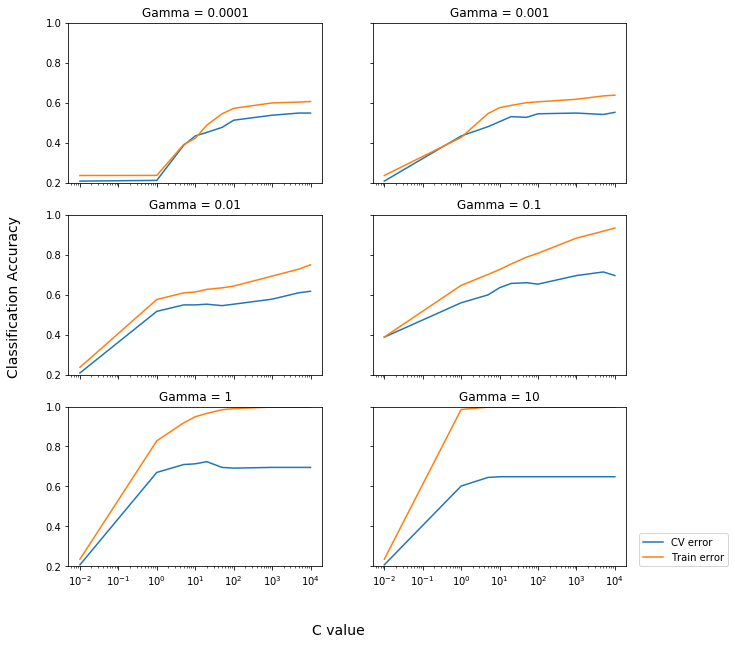

In [22]:
#model selection takes a few minutes, change this variable
#to true to run the parameter loop
do_model_selection = True

if do_model_selection:
    C_range = np.array([.01, 1, 5, 10, 20, 50, 100, 1000, 5000, 10000])
    gamma_range = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10])
    
    fig, axes = plt.subplots(3, 2, 
                        sharex='col', sharey='row',figsize=(10,10))
    plot_number = 0
    for outer_ind, gamma_value in enumerate(gamma_range):
        row = int(plot_number / 2)
        column = int(plot_number % 2)
        cv_errors = np.zeros(C_range.shape)
        train_errors = np.zeros(C_range.shape)
        for index, c_value in enumerate(C_range):
            
            clf = svm.SVC(C=c_value, gamma=gamma_value)
            clf.fit(X_train,y_train)
            
            train_conf = confusion_matrix(y_train, clf.predict(X_train))
            cv_conf = confusion_matrix(y_test, clf.predict(X_test))
        
            cv_errors[index] = accuracy(cv_conf)
            train_errors[index] = accuracy(train_conf)

        ax = axes[row, column]
        ax.set_title('Gamma = %g'%gamma_value)
        ax.semilogx(C_range, cv_errors, label='CV error')
        ax.semilogx(C_range, train_errors, label='Train error')
        plot_number += 1
        ax.set_ylim([0.2,1])
        
    ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
    fig.text(0.5, 0.03, 'C value', ha='center',
             fontsize=14)
             
    fig.text(0.04, 0.5, 'Classification Accuracy', va='center', 
             rotation='vertical', fontsize=14)

**EXERCISE 9:** Based on the plots shown above, which values of `gamma` and `C` are the best combination? Use those parameters to define, fit and predict the facies with SVM. Calculate the accuracy for facies and adjacent facies as done for the previous vanilla model.

In [23]:
# YOUR CODE HERE
model_SVM_best = svm.SVC(C=11, gamma=1)

model_SVM_best.fit(X_train, y_train)
predicted_labels = model_SVM_best.predict(X_test)
train_conf = confusion_matrix(y_train, model_SVM_best.predict(X_train))
cv_conf = confusion_matrix(y_test, model_SVM_best.predict(X_test))
print('optimized facies classification accuracy = %f' % accuracy(cv_conf))
print('optimized adjacent facies classification accuracy = %f' % accuracy_adjacent(cv_conf, adjacent_facies))
#... multiple lines of code
# fit on x train
# get confusion matrix
# get confusion for x_test(indivadual and adjacent)

optimized facies classification accuracy = 0.716846
optimized adjacent facies classification accuracy = 0.921147


Precision and recall are metrics that give more insight into how the classifier performs for individual facies.  Precision is the probability that given a classification result for a sample, the sample actually belongs to that class. Recall is the probability that a sample will be correctly classified for a given class.

Precision and recall can be computed easily using the confusion matrix. The code to do so has been added to the `display_confusion_matrix()` function:

In [24]:
display_cm(cv_conf, facies_labels, display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    18     5     1                                        24
     CSiS     1    48     9                                        58
     FSiS     1    13    25           1                            40
     SiSh           1     1    13                       1          16
       MS           1           2    14    10           3          30
       WS                       3     4    23     1     4          35
        D                       1     2           8                11
       PS                             2     9          40          51
       BS                                               3    11    14

Precision  0.90  0.71  0.69  0.68  0.61  0.55  0.89  0.78  1.00  0.73
   Recall  0.75  0.83  0.62  0.81  0.47  0.66  0.73  0.78  0.79  0.72
       F1  0.82  0.76  0.66  0.74  0.53  0.60  0.80  0.78  0.88  0.72


To interpret these results, consider facies `SS`.  In our test set, if a sample was labeled `SS` the probability the sample was correct is 0.90 (precision).  If we know a sample has facies `SS`, then the probability it will be correctly labeled by the classifier is 0.75 (recall).  It is desirable to have high values for both precision and recall, but often when an algorithm is tuned to increase one, the other decreases.  The F1 score combines both to give a single measure of relevancy of the classifier results.

These results can help guide intuition for how to improve the classifier results.  For example, for a sample with facies `MS` or mudstone, it is only classified correctly 47% of the time (recall).  Perhaps this could be improved by introducing more training samples.  Sample quality could also play a role.  Facies `BS` or bafflestone has the best `F1` score and relatively few training examples.  But this data was handpicked from other wells to provide training examples to identify this facies. _You may observe different results depending on your choice of `C` and `gamma`._

We can also consider the classification metrics when we consider misclassifying an adjacent facies as correct:

In [25]:
display_adj_cm(cv_conf, facies_labels, adjacent_facies, display_metrics = True, hide_zeros = True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    23           1                                        24
     CSiS          58                                              58
     FSiS     1          38           1                            40
     SiSh           1     1    13                       1          16
       MS           1                26                 3          30
       WS                       3          28           4          35
        D                       1     2           8                11
       PS                             2                49          51
       BS                                                    14    14

Precision  0.96  0.97  0.95  0.76  0.84  1.00  1.00  0.86  1.00  0.93
   Recall  0.96  1.00  0.95  0.81  0.87  0.80  0.73  0.96  1.00  0.92
       F1  0.96  0.98  0.95  0.79  0.85  0.89  0.84  0.91  1.00  0.92


Considering adjacent facies, the `F1` scores for all facies types are above 0.9, except when classifying `SiSh` or marine siltstone and shale.  The classifier often misclassifies this facies (recall of 0.75), most often as wackestone. 

### 3.3. Model performance on blind data

We held a well back from the training, and stored it in a dataframe called `blind`:

In [26]:
blind

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
471,2,A1 SH,SHANKLE,2774.5,98.36,0.642,-0.1,18.685,2.9,1,1.000
472,2,A1 SH,SHANKLE,2775.0,97.57,0.631,7.9,16.745,3.2,1,0.984
473,2,A1 SH,SHANKLE,2775.5,98.41,0.615,12.8,14.105,3.2,1,0.968
474,2,A1 SH,SHANKLE,2776.0,85.92,0.597,13.0,13.385,3.4,1,0.952
475,2,A1 SH,SHANKLE,2776.5,83.16,0.592,12.3,13.345,3.4,1,0.935
...,...,...,...,...,...,...,...,...,...,...,...
915,8,C LM,SHANKLE,3006.0,32.84,1.120,-2.2,3.455,5.1,2,0.060
916,8,C LM,SHANKLE,3006.5,25.16,1.112,-1.6,2.890,4.8,2,0.045
917,8,C LM,SHANKLE,3007.0,25.16,1.112,-1.6,2.890,4.8,2,0.030
918,4,C LM,SHANKLE,3007.5,26.22,1.092,-0.4,3.400,4.5,2,0.030


**EXERCISE 10:** Use the best SVM model to predict the facies of the blind set. Calculate the accuracy for facies and adjacent facies. _Hint: Check how we preprocessed the data first for the original dataset. Apply the same strategy._

In [27]:
correct_facies_labels_blind = blind['Facies'].values

# YOUR CODE HERE

feature_vectors_blind = blind.drop(['Facies', 'Formation', 'Well Name', 'Depth'], axis=1)
# feature_vectors_blind
scaler_blind = preprocessing.StandardScaler().fit(feature_vectors_blind)
scaled_features_blind = scaler.transform(feature_vectors_blind)
# scaled_features_blind

predicted_labels = model_SVM_best.predict(scaled_features_blind)

cv_conf = confusion_matrix(correct_facies_labels_blind, model_SVM_best.predict(scaled_features_blind))
print('optimized facies classification accuracy = %f' % accuracy(cv_conf))
print('optimized adjacent facies classification accuracy = %f' % accuracy_adjacent(cv_conf, adjacent_facies))

optimized facies classification accuracy = 0.452116
optimized adjacent facies classification accuracy = 0.841871


In [28]:
display_cm(cv_conf, facies_labels,
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    11    58    20                                        89
     CSiS    14    61    14                                        89
     FSiS     2    51    64                                       117
     SiSh                       2           5                       7
       MS                       3     3     2           9     2    19
       WS                 3     3    11    38          16          71
        D                 5     3     1           2     6          17
       PS                             2    13     2    22     1    40
       BS                                                           0

Precision  0.41  0.36  0.60  0.18  0.18  0.66  0.50  0.42  0.00  0.48
   Recall  0.12  0.69  0.55  0.29  0.16  0.54  0.12  0.55  0.00  0.45
       F1  0.19  0.47  0.57  0.22  0.17  0.59  0.19  0.47  0.00  0.43


C:\Users\79092\Desktop\地球科学与机器学习\chapter3\classification_utilities.py:14: RuntimeWarning: invalid value encountered in true_divide
  recall = np.diagonal(cm)/cm.sum(axis=1).astype('float')


In [29]:
display_adj_cm(cv_conf, facies_labels, adjacent_facies,
               display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    69          20                                        89
     CSiS          89                                              89
     FSiS     2         115                                       117
     SiSh                       2           5                       7
       MS                             8                 9     2    19
       WS                 3     3          49          16          71
        D                 5     3     1           8                17
       PS                             2                38          40
       BS                                                           0

Precision  0.97  1.00  0.80  0.25  0.73  0.91  1.00  0.60  0.00  0.87
   Recall  0.78  1.00  0.98  0.29  0.42  0.69  0.47  0.95  0.00  0.84
       F1  0.86  1.00  0.88  0.27  0.53  0.78  0.64  0.74  0.00  0.84


The model does relatively bad on the independent blind test but does well in the case of adjacent facies predictions. We will now compare the observations and predictions on the well itself. 

In [30]:
def compare_facies_plot(logs, pred_lab, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[pred_lab].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(pred_lab)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

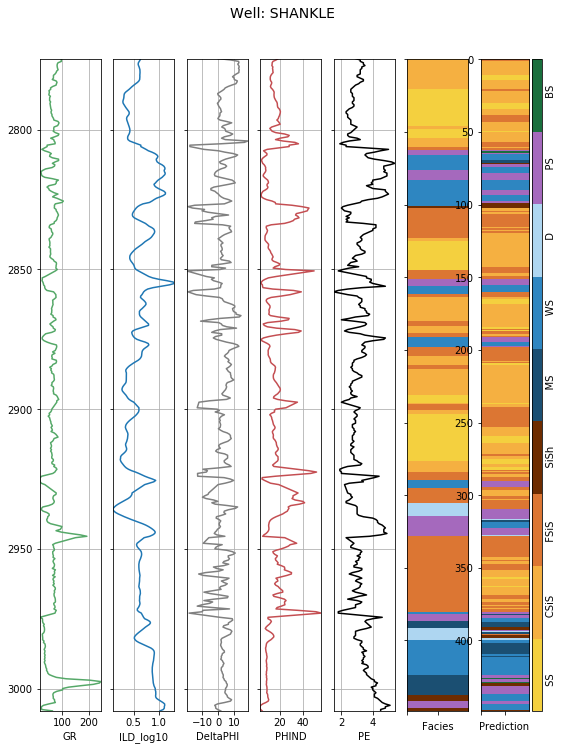

In [31]:
blind['Prediction'] = model_SVM_best.predict(scaled_features_blind)
compare_facies_plot(blind, 'Prediction', facies_colors)

### 3.4. Application to wells with no core data

Now that we have a trained facies classification model we can use it to identify facies in wells that do not have core data.  In this case, we will apply the classifier to two wells, but we could use it on any number of wells for which we have the same set of well logs for input.

This dataset is similar to the training data except it does not have facies labels (see file `Facies_validation_data_nofacies.csv`).

**EXERCISE 11:** Predict the unknown facies of the two wells with no core data and include a new column in the `well_data` data frame . _Hint: make sure to use the same preprocessing as done above._

In [31]:
well_data = pd.read_csv('Facies_validation_data_nofacies.csv')
well_data['Well Name'] = well_data['Well Name'].astype('category')

# YOUR CODE HERE
well_features = well_data.drop([ 'Formation', 'Well Name', 'Depth'], axis=1)
scaler_unknow = preprocessing.StandardScaler().fit(well_features)

X_unknown = scaler.transform(well_features)
y_unknown =  model_SVM_best.predict(X_unknown)

well_data['Facies'] = y_unknown
well_data


# compare_facies_plot(blind, 'Prediction', facies_colors)

# well_data['Prediction'] = model_SVM_best.predict(scaled_features_blind)
# compare_facies_plot(blind, 'Prediction', facies_colors)

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,A1 SH,STUART,2808.0,66.276,0.630,3.300,10.650,3.591,1,1.000,3
1,A1 SH,STUART,2808.5,77.252,0.585,6.500,11.950,3.341,1,0.978,3
2,A1 SH,STUART,2809.0,82.899,0.566,9.400,13.600,3.064,1,0.956,3
3,A1 SH,STUART,2809.5,80.671,0.593,9.500,13.250,2.977,1,0.933,3
4,A1 SH,STUART,2810.0,75.971,0.638,8.700,12.350,3.020,1,0.911,1
...,...,...,...,...,...,...,...,...,...,...,...
825,C SH,CRAWFORD,3158.5,86.078,0.554,5.040,16.150,3.161,1,0.639,3
826,C SH,CRAWFORD,3159.0,88.855,0.539,5.560,16.750,3.118,1,0.611,3
827,C SH,CRAWFORD,3159.5,90.490,0.530,6.360,16.780,3.168,1,0.583,3
828,C SH,CRAWFORD,3160.0,90.975,0.522,7.035,16.995,3.154,1,0.556,3


In [32]:
well_data['Well Name'].unique()

[STUART, CRAWFORD]
Categories (2, object): [STUART, CRAWFORD]

**EXERCISE 12:** Plot the classification results along with the well logs using the plotting function defined earlier.

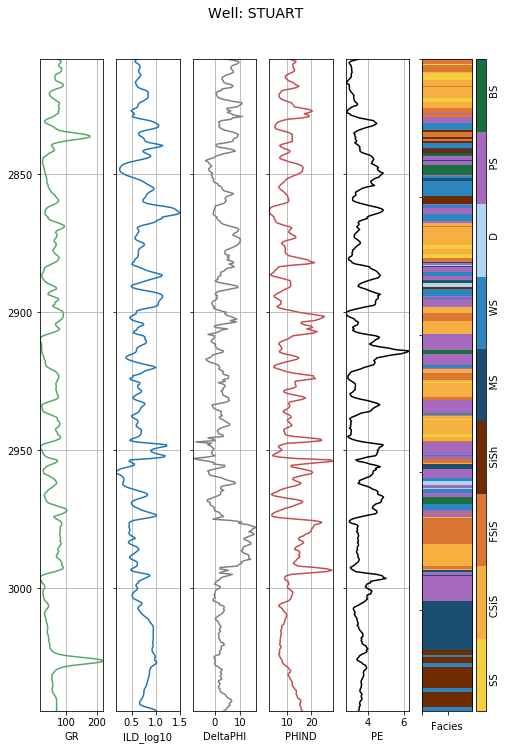

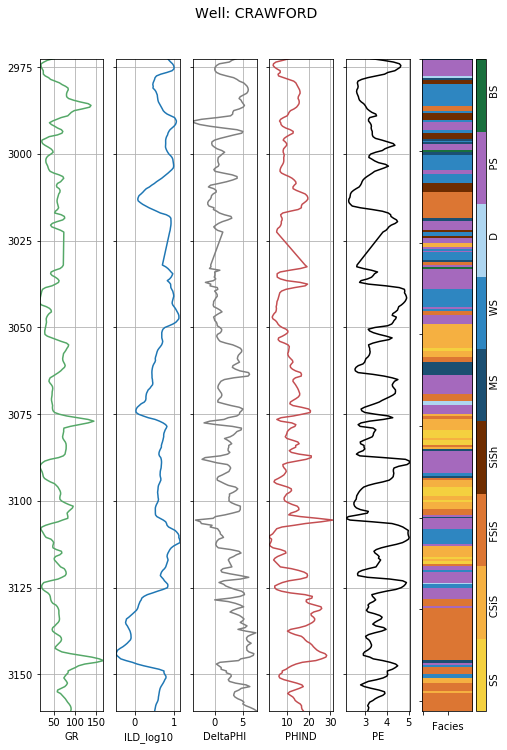

In [33]:
# YOUR CODE HERE
make_facies_log_plot(well_data[well_data['Well Name']=='STUART'], facies_colors)
make_facies_log_plot(well_data[well_data['Well Name']=='CRAWFORD'], facies_colors)


## 4. Decision tree ensemble models

**EXERCISES 13-17:** It is now time to do better than the SVM baseline model (i.e. better than 0.45 accuracy)! You could get inspiration from the results discussed in Hall & Hall (2017). Tens of models are available on the competition's GitHub repository https://github.com/seg/2016-ml-contest. You can also have a look at the models defined in the chapter 2b notebook - Good luck!

NB: For each model tested:
* Provide the accuracy for the exact facies for the validation set (from the training/test set split)
* Provide the accuracy for the exact facies for the blind data
* Plot the results using `compare_facies_plot`.

Propose 5 models (i.e. the 5 exercises) of which at least one should perform better than the SVM baseline.

In [38]:
# YOUR CODE HERE
# ##############################
# import pakage here
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import xgboost
import lightgbm
# ##############################

best parameters:
{'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 4}

 accuracy on test set
Facies classification accuracy = 0.602151

 accuracy on blind data
Facies classification accuracy = 0.425390


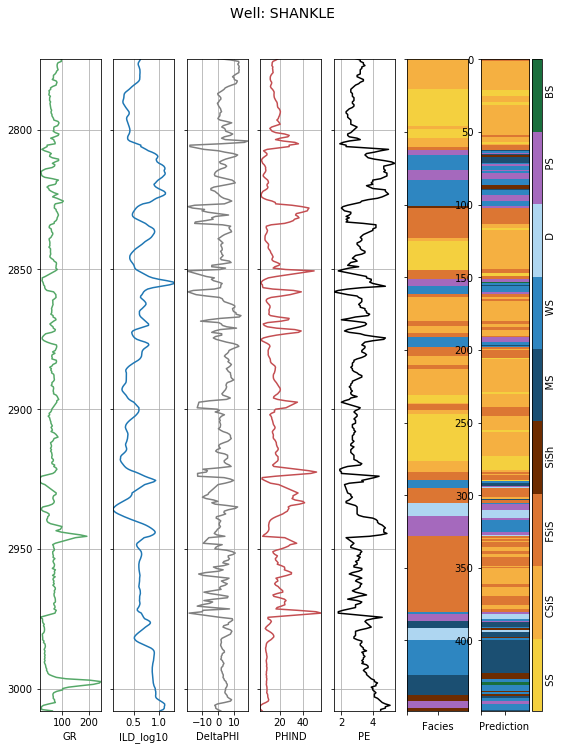

In [36]:
# YOUR CODE HERE
# ##############################
# model 1: grid search
# ##############################
from sklearn.model_selection import GridSearchCV
params = {'max_depth':[2,4,6,8,10,12,14,16,18,20,22,24],'min_samples_split':[2,3,4,5,6,7],'min_samples_leaf':[1,2,3,4]}
modelgridsearch = DecisionTreeClassifier()
gcv = GridSearchCV(estimator = modelgridsearch, param_grid = params)
gcv.fit(X_train, y_train)
model_best = gcv.best_estimator_
model_best.fit(X_train, y_train) 
y_test_predict = model_best.predict(X_test)
print('best parameters:')
print(gcv.best_params_)
conf = confusion_matrix(y_test, y_test_predict)
print('\n accuracy on test set')
print('Facies classification accuracy = %f' % accuracy(conf))
# print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))
y_test_predict_blind = model_best.predict(scaled_features_blind)
conf_blind = confusion_matrix(correct_facies_labels_blind,y_test_predict_blind)
print('\n accuracy on blind data')
print('Facies classification accuracy = %f' % accuracy(conf_blind))
# print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf_blind, adjacent_facies))
blind['Prediction'] = y_test_predict_blind
compare_facies_plot(blind, 'Prediction', facies_colors)


 accuracy on test set
Facies classification accuracy = 0.688172

 accuracy on blind data
Facies classification accuracy = 0.487751


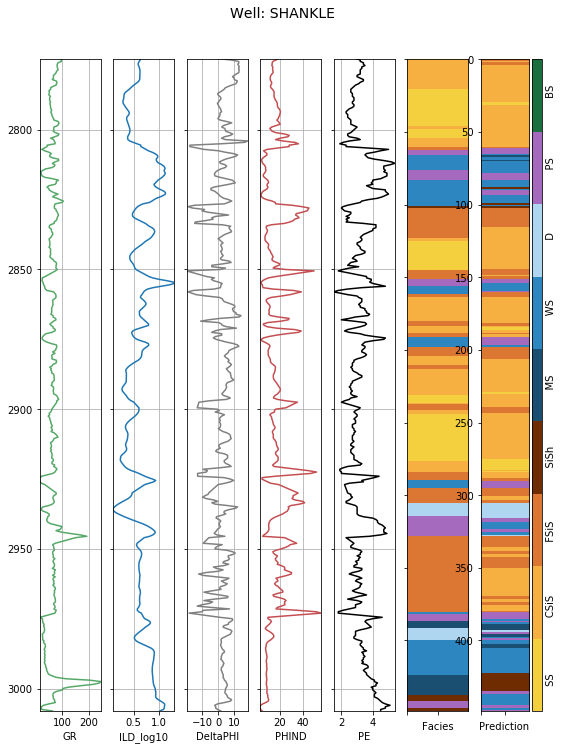

In [37]:
# YOUR CODE HERE
# ##############################
# model 2 bagging
# ##############################
model_bag_ = BaggingClassifier(DecisionTreeClassifier(), n_estimators = 100, max_samples = .7)
model_bag_.fit(X_train, y_train) 
y_test_predict = model_bag_.predict(X_test)
conf = confusion_matrix(y_test, y_test_predict)
print('\n accuracy on test set')
print('Facies classification accuracy = %f' % accuracy(conf))
# print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))
y_test_predict_blind = model_bag_.predict(scaled_features_blind)
conf_blind = confusion_matrix(correct_facies_labels_blind,y_test_predict_blind)
print('\n accuracy on blind data')
print('Facies classification accuracy = %f' % accuracy(conf_blind))
# print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf_blind, adjacent_facies))
blind['Prediction'] = y_test_predict_blind
compare_facies_plot(blind, 'Prediction', facies_colors)


 accuracy on test set
Facies classification accuracy = 0.698925

 accuracy on blind data
Facies classification accuracy = 0.516704


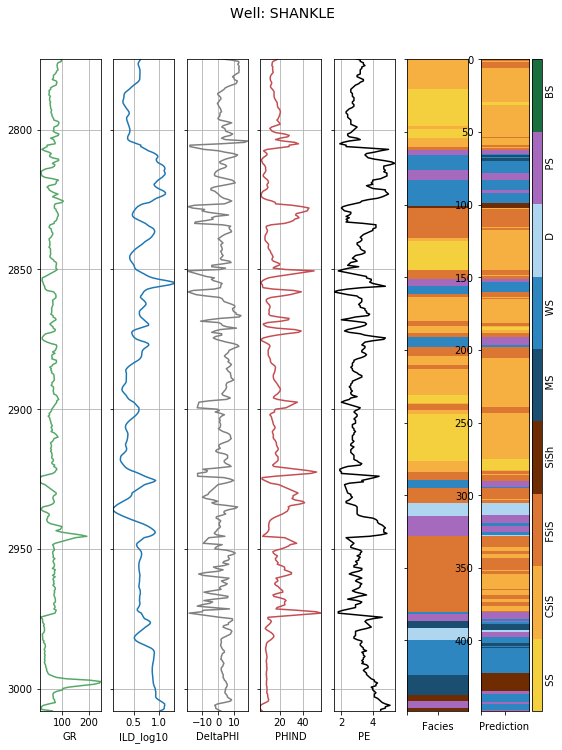

In [38]:
# YOUR CODE HERE
# ##############################
# model 3 random forest
# ##############################
model_RF = RandomForestClassifier(n_estimators=200, random_state=0)
model_RF.fit(X_train, y_train) 
y_test_predict = model_RF.predict(X_test)
conf = confusion_matrix(y_test, y_test_predict)
print('\n accuracy on test set')
print('Facies classification accuracy = %f' % accuracy(conf))
# print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))
y_test_predict_blind = model_RF.predict(scaled_features_blind)
conf_blind = confusion_matrix(correct_facies_labels_blind,y_test_predict_blind)
print('\n accuracy on blind data')
print('Facies classification accuracy = %f' % accuracy(conf_blind))
# print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf_blind, adjacent_facies))
blind['Prediction'] = y_test_predict_blind
compare_facies_plot(blind, 'Prediction', facies_colors)


 accuracy on test set
Facies classification accuracy = 0.648746

 accuracy on blind data
Facies classification accuracy = 0.481069


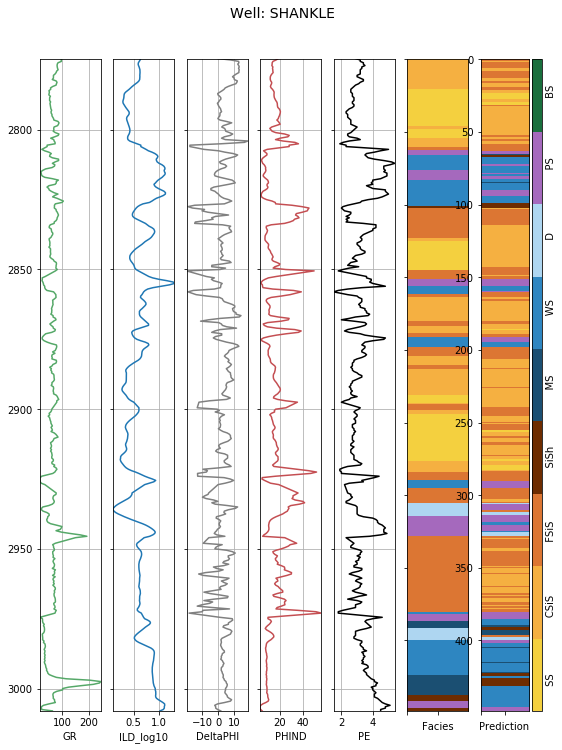

In [39]:
# YOUR CODE HERE
# ##############################
# model 4 Boosting
# ##############################
model_ada_ = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=100, learning_rate=1, algorithm='SAMME')
model_ada_.fit(X_train, y_train) 
y_test_predict = model_ada_.predict(X_test)
conf = confusion_matrix(y_test, y_test_predict)
print('\n accuracy on test set')
print('Facies classification accuracy = %f' % accuracy(conf))
# print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))
y_test_predict_blind = model_ada_.predict(scaled_features_blind)
conf_blind = confusion_matrix(correct_facies_labels_blind,y_test_predict_blind)
print('\n accuracy on blind data')
print('Facies classification accuracy = %f' % accuracy(conf_blind))
# print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf_blind, adjacent_facies))
blind['Prediction'] = y_test_predict_blind
compare_facies_plot(blind, 'Prediction', facies_colors)

best parameters:
{'max_depth': 28, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150, 'random_state': 2}

 accuracy on test set
Facies classification accuracy = 0.691756

 accuracy on blind data
Facies classification accuracy = 0.507795


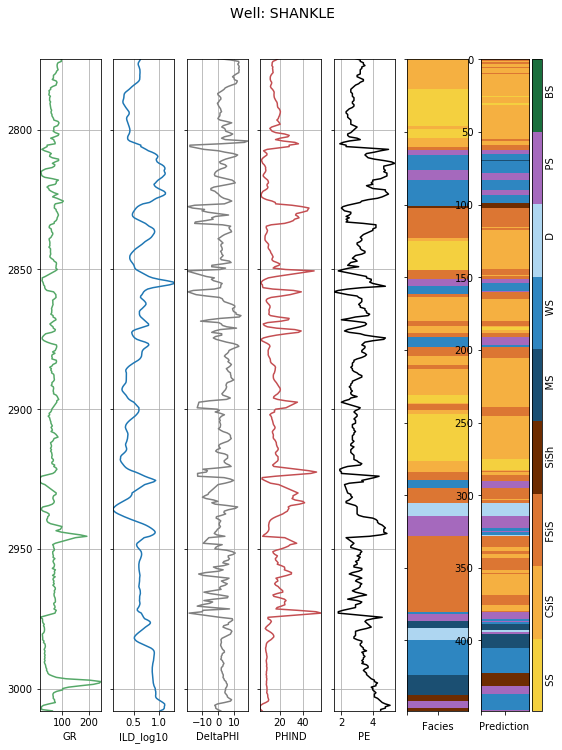

In [44]:
# YOUR CODE HERE
# ##############################
# model 5 grid search of random forest
# ##############################
params = {'random_state':[0,1,2],'n_estimators':[100,150,200,250] ,'max_depth':[18,20,22,24,26,28,30],'min_samples_split':[2,3,4,5],'min_samples_leaf':[1,2,3]}
modelgridsearch = RandomForestClassifier()
gcv = GridSearchCV(estimator = modelgridsearch, param_grid = params)
gcv.fit(X_train, y_train)
model_best = gcv.best_estimator_
model_best.fit(X_train, y_train) 
y_test_predict = model_best.predict(X_test)
print('best parameters:')
print(gcv.best_params_)
conf = confusion_matrix(y_test, y_test_predict)
print('\n accuracy on test set')
print('Facies classification accuracy = %f' % accuracy(conf))
# print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))
y_test_predict_blind = model_best.predict(scaled_features_blind)
conf_blind = confusion_matrix(correct_facies_labels_blind,y_test_predict_blind)
print('\n accuracy on blind data')
print('Facies classification accuracy = %f' % accuracy(conf_blind))
# print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf_blind, adjacent_facies))
blind['Prediction'] = y_test_predict_blind
compare_facies_plot(blind, 'Prediction', facies_colors)

D:\software\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:48:28] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 accuracy on test set
Facies classification accuracy = 0.713262

 accuracy on blind data
Facies classification accuracy = 0.485523


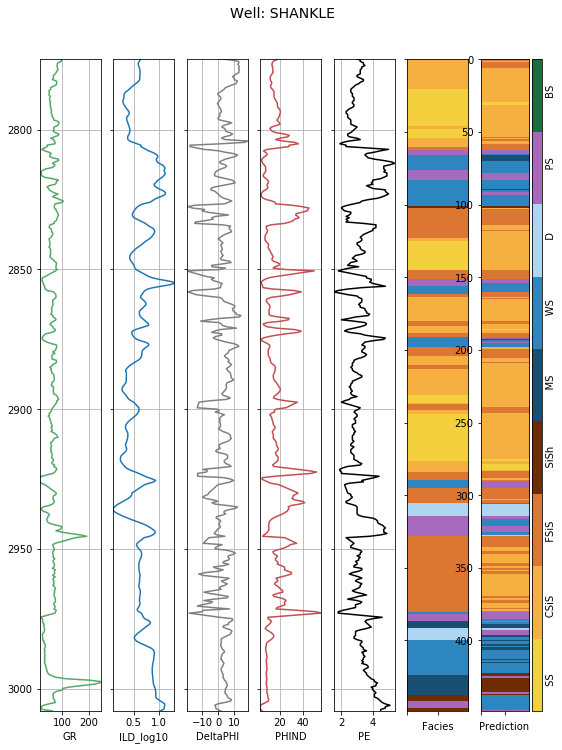

In [37]:
# YOUR CODE HERE
# ##############################
# model 6 xgbclassifier
# ##############################
model_xgb = xgboost.XGBClassifier()
model_xgb.fit(X_train, y_train) 
y_test_predict = model_xgb.predict(X_test)
conf = confusion_matrix(y_test, y_test_predict)
print('\n accuracy on test set')
print('Facies classification accuracy = %f' % accuracy(conf))
# print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))
y_test_predict_blind = model_xgb.predict(scaled_features_blind)
conf_blind = confusion_matrix(correct_facies_labels_blind,y_test_predict_blind)
print('\n accuracy on blind data')
print('Facies classification accuracy = %f' % accuracy(conf_blind))
# print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf_blind, adjacent_facies))
blind['Prediction'] = y_test_predict_blind
compare_facies_plot(blind, 'Prediction', facies_colors)


 accuracy on test set
Facies classification accuracy = 0.709677

 accuracy on blind data
Facies classification accuracy = 0.461024


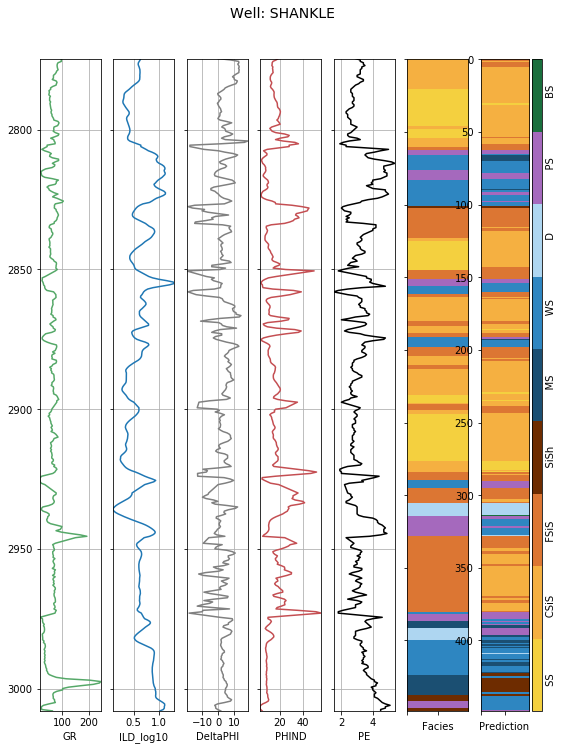

In [40]:
# YOUR CODE HERE
# ##############################
# model 7 lightgbm
# ##############################
model_LGBM = lightgbm.LGBMClassifier(objective = 'multiclass')
model_LGBM.fit(X_train, y_train) 
y_test_predict = model_LGBM.predict(X_test)
conf = confusion_matrix(y_test, y_test_predict)
print('\n accuracy on test set')
print('Facies classification accuracy = %f' % accuracy(conf))
# print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))
y_test_predict_blind = model_LGBM.predict(scaled_features_blind)
conf_blind = confusion_matrix(correct_facies_labels_blind,y_test_predict_blind)
print('\n accuracy on blind data')
print('Facies classification accuracy = %f' % accuracy(conf_blind))
# print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf_blind, adjacent_facies))
blind['Prediction'] = y_test_predict_blind
compare_facies_plot(blind, 'Prediction', facies_colors)